In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv
import pandas as pd

# Investigate how bootstrap confidence intervals are affected by upscaling (bayNorm)

Consider the 'SS3_c57_UMIs_concat.csv' dataset:
- observed counts (original)
- MAP counts (argmax count of posterior)
- Posterior sample counts (20 sampled counts from posterior)

Take the sample of counts for a gene for all 3, bootstrap to produce confidence intervals for all states ('s stationary values), plot them against the histogram of the (stationary) sample:

### Load datasets

In [16]:
# Observed count data
data_OB = pd.read_csv("..\Data\SS3_c57_UMIs_concat_cleaned.csv", index_col="Unnamed: 0")
data_OB.head()

,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S18,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S1,SS3_MAF_Leo171129_p2_S20,...,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S186,SS3_MAF_leo180223_p4_S187,SS3_MAF_leo180223_p4_S191,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610007P14Rik,0.0,2.0,2.0,2.0,1.0,4.0,4.0,4.0,7.0,2.0,...,1.0,3.0,0.0,1.0,2.0,9.0,4.0,0.0,0.0,0.0
0610009B22Rik,10.0,4.0,NaN,NaN,0.0,14.0,26.0,6.0,1.0,2.0,...,6.0,5.0,2.0,1.0,14.0,0.0,1.0,4.0,3.0,2.0
0610031J06Rik,17.0,18.0,9.0,14.0,0.0,9.0,6.0,22.0,1.0,10.0,...,18.0,9.0,3.0,2.0,8.0,31.0,15.0,1.0,1.0,2.0
1110007C09Rik,1.0,0.0,4.0,9.0,0.0,0.0,NaN,0.0,NaN,0.0,...,4.0,2.0,NaN,6.0,0.0,0.0,5.0,0.0,2.0,0.0
1110037F02Rik,0.0,0.0,4.0,0.0,2.0,10.0,0.0,2.0,8.0,0.0,...,2.0,4.0,0.0,1.0,4.0,3.0,6.0,0.0,0.0,3.0


In [3]:
# MAP count data
data_MAP = pd.read_csv("..\Data\SS3_c57_UMIs_concat_MAP.csv", index_col="Unnamed: 0")
data_MAP.head()

,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S18,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S1,SS3_MAF_Leo171129_p2_S20,...,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S186,SS3_MAF_leo180223_p4_S187,SS3_MAF_leo180223_p4_S191,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610007P14Rik,1,22,23,24,13,21,29,35,76,16,...,11,28,2,26,21,76,40,1,2,2
0610009B22Rik,133,49,10,10,11,75,186,58,20,22,...,69,52,60,43,144,7,18,59,59,48
0610031J06Rik,272,230,139,205,34,60,62,224,41,105,...,228,111,144,133,113,294,184,48,64,91
1110007C09Rik,12,0,48,114,0,0,0,0,0,0,...,44,18,0,184,0,0,53,0,34,0
1110037F02Rik,6,5,44,5,27,51,3,19,80,4,...,23,37,10,28,40,26,57,6,7,50


In [5]:
# Posterior sample count data
data_PS = pd.read_csv("..\Data\SS3_c57_UMIs_concat_PosteriorSamples.csv", index_col="Unnamed: 0")
data_PS.head()

,SS3_MAF_Leo171129_p2_S10.1,SS3_MAF_Leo171129_p2_S12.1,SS3_MAF_Leo171129_p2_S13.1,SS3_MAF_Leo171129_p2_S14.1,SS3_MAF_Leo171129_p2_S16.1,SS3_MAF_Leo171129_p2_S17.1,SS3_MAF_Leo171129_p2_S18.1,SS3_MAF_Leo171129_p2_S19.1,SS3_MAF_Leo171129_p2_S1.1,SS3_MAF_Leo171129_p2_S20.1,...,SS3_MAF_leo180223_p4_S182.20,SS3_MAF_leo180223_p4_S186.20,SS3_MAF_leo180223_p4_S187.20,SS3_MAF_leo180223_p4_S191.20,SS3_MAF_leo180223_p4_S185.20,SS3_MAF_leo180223_p4_S189.20,SS3_MAF_leo180223_p4_S188.20,SS3_MAF_leo180223_p4_S190.20,SS3_MAF_leo180223_p4_S98.20,SS3_MAF_leo180223_p4_S99.20
0610007P14Rik,2,60,54,46,26,8,35,19,106,17,...,10,12,22,37,22,62,55,25,18,23
0610009B22Rik,121,59,30,15,42,61,230,58,39,54,...,30,41,114,57,209,4,38,48,92,53
0610031J06Rik,234,268,195,198,56,44,113,203,76,85,...,255,110,170,211,165,358,165,57,173,226
1110007C09Rik,79,11,34,106,2,1,0,7,11,4,...,44,21,44,210,1,2,99,19,36,9
1110037F02Rik,20,0,79,21,17,93,14,24,47,8,...,30,57,61,137,77,29,67,12,36,37


### Bootstrap code

In [38]:
def bootstrap_data(x_list, samples, N, plot=False, printing=False):
    """
    Bootstrap sample data to find confidence intervals of
    stationary distribution values.

    Inputs:
    x_list: states to calculate stationary estimates for
    samples: list of samples from stationary distribution (counts of transcripts)
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of states in x_list
    """

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    n = len(samples)
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(samples,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return intervals

In [87]:
def CI_analysis(sample, N):
    """
    Given a sample from a (stationary) distribution, create N bootstrap samples
    and estimate confidence intervals for all probabilities in the distribution,
    plot sample and CI's
    """
    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data([x for x in range(x_max + 1)], sample, N)

    # average width (4 d.p)
    avg_width = np.mean([interval[1] - interval[0] for interval in intervals])
    avg_width = float(str(avg_width)[:6])

    # plot sample and CI bounds
    label_dot = "[0, 0] CI"
    label_int = "Confidence interval"
    for i, interval in enumerate(intervals):
        if interval[0] == interval[1]:
            # plot dot for CI of width 0
            plt.plot(i, 0, 'go', label = label_dot)
            # avoid repeated legend
            label_dot = ""
        else:
            plt.plot([i, i], [interval[0], interval[1]], color="red", label = label_int)
            # avoid repeated legend
            label_int = ""
    plt.hist(sample, bins=np.arange(x_max) - 0.5, color="blue", label="Sample", alpha=0.5,
             density=True)
    plt.plot([0,0], label=f"Average bound width = {avg_width}")
    plt.title("Sample and estimated bounds for a gene's transcript count distribution")
    plt.legend()
    plt.show()

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


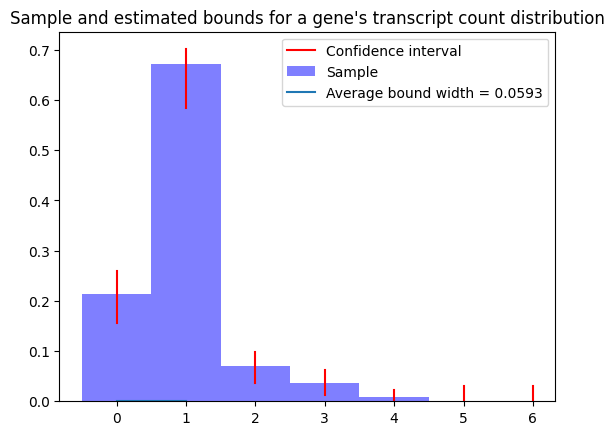

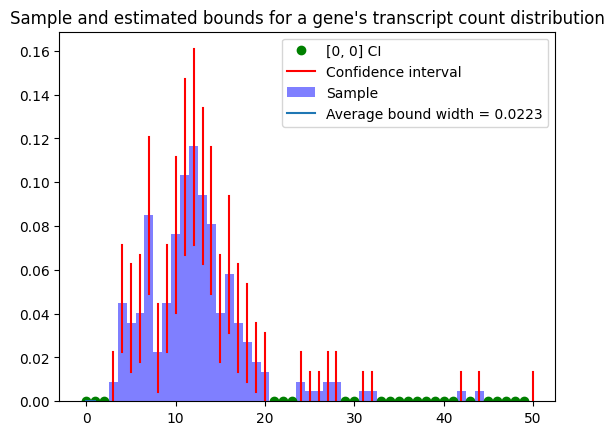

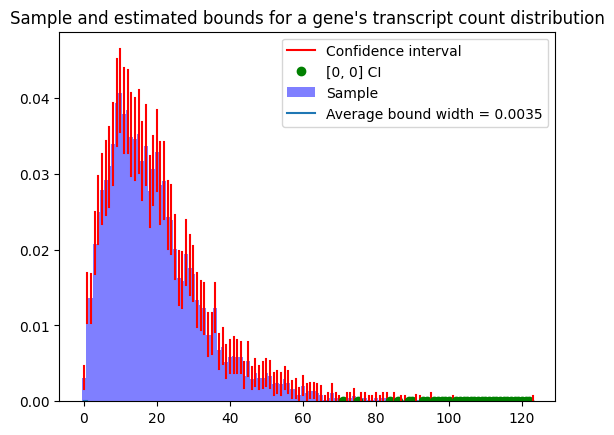

In [88]:
for data in [data_OB, data_MAP, data_PS]:
    sample = data.iloc[1483]
    CI_analysis(sample, 1000)

Increased spread of data from 0-6 to 0-50 for the MAP data, and to 0-120 and 20x sample size for PS data. MAP average width around half of observed, PS around a tenth, however likely strong influence of 0 width confidence intervals due to no observations for those states.

In [89]:
def cleaned_average_width(sample, N):
    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data([x for x in range(x_max + 1)], sample, N)

    avg_width = []
    for interval in intervals:
        if interval[0] != interval[1]:
            avg_width.append(interval[1] - interval[0])
    
    return np.mean(avg_width)

In [90]:
for data in [data_OB, data_MAP, data_PS]:
    sample = data.iloc[1483]
    avg_width = cleaned_average_width(sample, 1000)
    print(avg_width)

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


0.061240433673469395
0.04050940688775511
0.004854414682539683


Removing 0 width confidence intervals when computing average width there is now only a small reduction when using MAP data. However, still a significant reduction when using PS data: 20 times sample size has strong impact on CI width as seen in birth_death_reaction analysis, and likely increased accuracy towards the theoretical 95%.

In [93]:
rng = np.random.default_rng(33)
OB_widths = []
MAP_widths = []
PS_widths = []
for i in rng.choice(data_OB.shape[0], size = 10):
    for j in range(3):
        sample = [data_OB, data_MAP, data_PS][j].iloc[i]
        [OB_widths, MAP_widths, PS_widths][j].append(cleaned_average_width(sample, 1000))

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


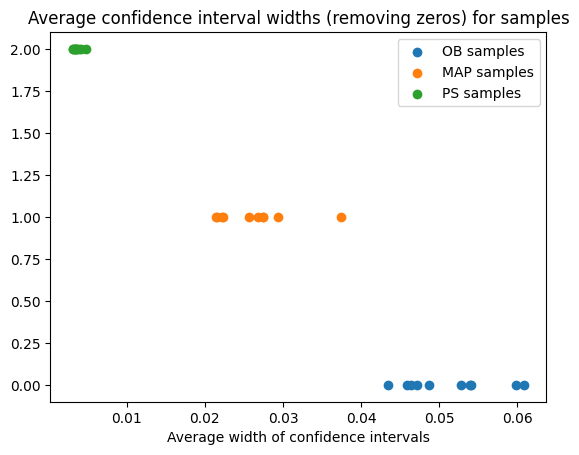

In [94]:
plt.scatter(OB_widths, [0] * len(OB_widths), label = "OB samples")
plt.scatter(MAP_widths, [1] * len(MAP_widths), label = "MAP samples")
plt.scatter(PS_widths, [2] * len(PS_widths), label = "PS samples")
plt.title("Average confidence interval widths (removing zeros) for samples")
plt.xlabel("Average width of confidence intervals")
plt.legend()
plt.show()

# Optimization

Current code for analysing samples: selecting state space truncation, bootstrapping sample and solving the selected LP. Currently quite slow even for the small number of states involved in OB data, but extremely so for the larger numbers of states in MAP and PS data.

Time bootstrap and LP solver for different numbers of states and equations, find optimizations

In [95]:
import time

## Timing bootstrap

In [99]:
def bootstrap_time(sample, n):
    """Time bootstrap for all states in sample, n = bootstrap samples."""
    start = time.time()
    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data([x for x in range(x_max + 1)], sample, n)

    # time
    end = time.time()

    # return: time elapsed, number of bounds estimated
    return (end - start, x_max + 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


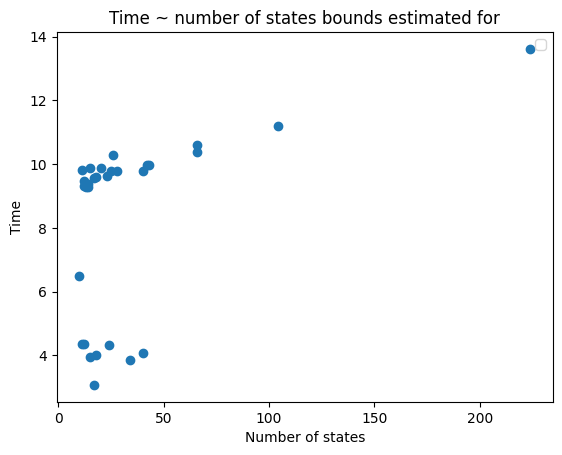

In [106]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_OB.shape[0], size = 30):
    sample = data_OB.iloc[i]
    t, s = bootstrap_time(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


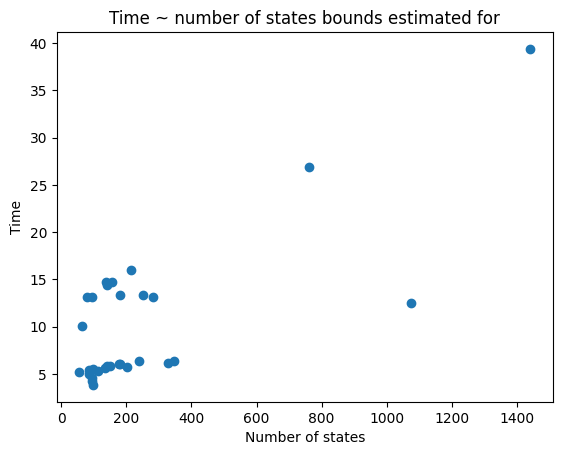

In [107]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_MAP.shape[0], size = 30):
    sample = data_MAP.iloc[i]
    t, s = bootstrap_time(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

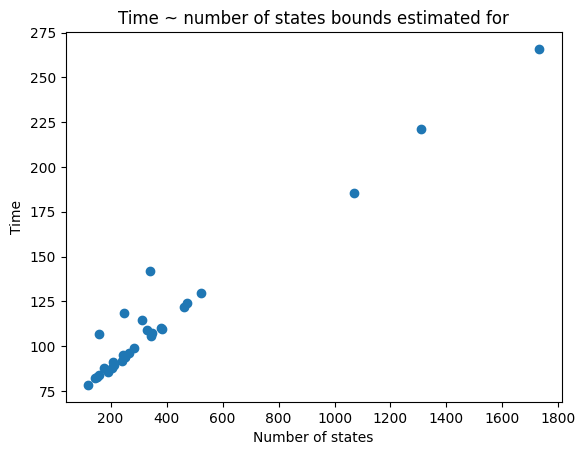

In [108]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_PS.shape[0], size = 30):
    sample = data_PS.iloc[i]
    t, s = bootstrap_time(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

Observed samples take around 10 seconds (if not less) for most samples of < 50 states with a slight linear trend up to ~14 seconds for the samples of ~200 states.

MAP samples with < 400 states take < around 15 seconds, with samples of up to ~1000 states taking up to ~40 seconds. 

However, PS samples are 20 times larger and include the increased number of states as in the MAP samples (and even more). See a linear relationship, with a gradient of ~0.1 (1 more state in the sample increases the time by 0.1 seconds, with a base time of ~75 seconds). These times of up to 5 minutes are too slow.

## New bootstrap code

In [117]:
# sample of states 
sample = [0, 0, 2, 3, 3, 5]
# maximum state observed
x_max = int(np.nanmax(sample))
# add 1 occurance of every state (needed as unique will ignore states that do not appear, messing up order of intervals)
sample += [x for x in range(6)]
# find number of occurances of each state
uni, counts = np.unique(sample, return_counts=True)
# subtract off the 1 added occurance from every state
counts - 1

array([2, 0, 1, 2, 0, 1], dtype=int64)

In [119]:
# sample of states, size n
sample = [0, 0, 2, 3, 3, 5]
# N bootstrap samples as rows in a N x n array
N = 3
n = len(sample)
bootstrap = np.random.choice(sample, size=(N, n))
bootstrap

array([[5, 2, 2, 0, 2, 2],
       [0, 3, 2, 2, 0, 0],
       [5, 0, 2, 0, 0, 3]])

In [147]:
# sample of states, size n
sample = [0, 0, 2, 3, 3, 5]
# maximum state observed
x_max = int(np.nanmax(sample))
# N bootstrap samples as rows in a N x n array
N = 3
n = len(sample)
bootstrap = np.random.choice(sample, size=(N, n))
print(bootstrap)
# append 1 occurance of every state to each row of bootstrap
added = np.repeat(np.arange(x_max + 1), N).reshape(x_max + 1, N).T
bootstrap = np.concatenate((bootstrap, added), axis=1)
print(bootstrap)
# find number of occurances of each state
uni, counts = np.unique(bootstrap, return_counts=True, axis=1)
# subtract off the 1 added occurance from every state
uni, counts

[[0 3 5 5 5 0]
 [0 0 2 0 3 3]
 [5 5 2 3 2 0]]
[[0 3 5 5 5 0 0 1 2 3 4 5]
 [0 0 2 0 3 3 0 1 2 3 4 5]
 [5 5 2 3 2 0 0 1 2 3 4 5]]


(array([[0, 0, 0, 1, 2, 3, 3, 4, 5, 5, 5, 5],
        [0, 0, 3, 1, 2, 0, 3, 4, 0, 2, 3, 5],
        [0, 5, 0, 1, 2, 5, 3, 4, 3, 2, 2, 5]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

Problem is that np.unique is treating the 12 3x1 columns (or 3 1x12 rows) as the values to find counts for so produces a list of 12 1's (as here all columns are unique (appear once each))

### np.bincount

Given a list and a number of bins (minlength sets the minimum number of bins), each bin counts the number of occurances of its index value in the list. 

Could set each row to have x_max + 1 bins to count occurances of states 0, 1, ..., x_max BUT can vectorise: add multiple of x_max + 1 to each row, then can flatten and use N * (x_max + 1) bins to equivalently count states in each row all at once, then reshape occurances to N * (x_max + 1) to give counts of 0, 1, ..., x_max for each of the N rows:

In [152]:
# sample of states, size n
sample = [0, 0, 2, 3, 3, 5]
# maximum state observed
x_max = int(np.nanmax(sample))
# N bootstrap samples as rows in a N x n array
N = 3
n = len(sample)
bootstrap = np.random.choice(sample, size=(N, n))
print(f"Bootstrap samples: \n{bootstrap}")
# offset each row by multiple of x_max + 1
bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
print(f"Offset: \n{bootstrap_offs}")
counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
print(f"Counts: \n{counts}")

Bootstrap samples: 
[[0 3 3 0 0 3]
 [0 0 2 3 0 5]
 [3 0 5 5 5 5]]
Offset: 
[[ 0  3  3  0  0  3]
 [ 6  6  8  9  6 11]
 [15 12 17 17 17 17]]
Counts: 
[[3 0 0 3 0 0]
 [3 0 1 1 0 1]
 [1 0 0 1 0 4]]


In [209]:
# both methods can select nan's
sample = [None, None, 0]
print(random.choices(sample,k=3))
print(np.random.choice(sample, size=3))

[0, None, 0]
[None None None]


In [234]:
# percentiles per column
x = np.array([[0, 0, 0, 9], [1, 1, 1, 10], [2, 2, 2, 11]])
print(x)
y = np.quantile(x, [0.025, 0.975], axis=0)
print(y)
[list(y[:,i]) for i in range(4)]

[[ 0  0  0  9]
 [ 1  1  1 10]
 [ 2  2  2 11]]
[[ 0.05  0.05  0.05  9.05]
 [ 1.95  1.95  1.95 10.95]]


[[0.05, 1.95], [0.05, 1.95], [0.05, 1.95], [9.05, 10.95]]

Implement new method, also changing from x_list to computing all intervals up to maximum state observed in sample

NOTE: in old method missing values (nan's) were resampled and added to length (n) but were not counted. Change to either discarding or replacing by 0

In [237]:
def bootstrap_data_optim(samples, N, plot=False, printing=False, drop_missing=False):
    """
    Bootstrap sample data to find confidence intervals of
    stationary distribution values.

    Inputs:
    samples: sample from stationary distribution (counts of transcripts)
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's
    drop_missing: whether to drop missing values from the sample,
        or replace them with 0 (as used when preparing BayNorm data)

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of all states up to largest observed
    """

    # drop missing values
    if drop_missing:
        samples = samples.dropna()
    # replace with 0
    else:
        samples = samples.fillna(value=0.0)

    # change to int
    samples = samples.astype('int64')
    # maximum state observed
    x_max = int(np.nanmax(samples))
    # size of sample
    n = len(samples)

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(samples, size=(N, n))
    # produce N x (x_max + 1) array of counts of states:
    # offset each row by multiple of x_max + 1 for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(x_max + 1)]

    # plot histograms and CI
    for x in range(x_max + 1):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
        if plot:
            plt.hist(counts[:, x] / n)
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[x][0], color="red")
            plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

In [243]:
sample = data_OB.iloc[0]
intervals = bootstrap_data_optim(sample, 1000)

## Almost instant!!!

# Test optimized bootstrap code

In [241]:
def bootstrap_time_optim(sample, N):
    """Time bootstrap for all states in sample, N = bootstrap samples."""
    start = time.time()

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, N)

    # time
    end = time.time()

    # return: time elapsed, number of bounds estimated
    return (end - start, len(intervals))

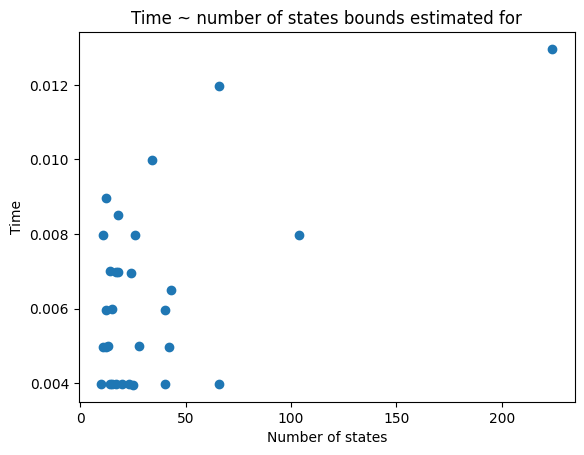

In [247]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_OB.shape[0], size = 30):
    sample = data_OB.iloc[i]
    t, s = bootstrap_time_optim(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

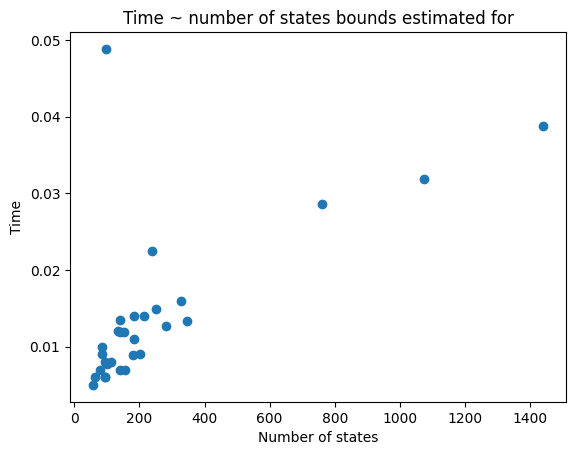

In [248]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_MAP.shape[0], size = 30):
    sample = data_MAP.iloc[i]
    t, s = bootstrap_time_optim(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

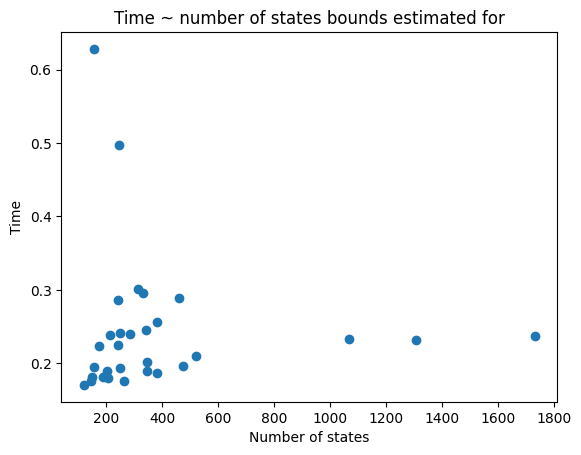

In [249]:
rng = np.random.default_rng(33)
times = []
states = []
for i in rng.choice(data_PS.shape[0], size = 30):
    sample = data_PS.iloc[i]
    t, s = bootstrap_time_optim(sample, 1000)
    times.append(t)
    states.append(s)

plt.scatter(states, times)
plt.title("Time ~ number of states bounds estimated for")
plt.xlabel("Number of states")
plt.ylabel("Time")
plt.show()

# Compare intervals to check consistent

In [250]:
def CI_analysis_optim(sample, N):
    """
    Given a sample from a (stationary) distribution, create N bootstrap samples
    and estimate confidence intervals for all probabilities in the distribution,
    plot sample and CI's
    """
    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, N)

    # average width (4 d.p)
    avg_width = np.mean([interval[1] - interval[0] for interval in intervals])
    avg_width = float(str(avg_width)[:6])

    # plot sample and CI bounds
    label_dot = "[0, 0] CI"
    label_int = "Confidence interval"
    for i, interval in enumerate(intervals):
        if interval[0] == interval[1]:
            # plot dot for CI of width 0
            plt.plot(i, 0, 'go', label = label_dot)
            # avoid repeated legend
            label_dot = ""
        else:
            plt.plot([i, i], [interval[0], interval[1]], color="red", label = label_int)
            # avoid repeated legend
            label_int = ""
    plt.hist(sample, bins=np.arange(x_max) - 0.5, color="blue", label="Sample", alpha=0.5,
             density=True)
    plt.plot([0,0], label=f"Average bound width = {avg_width}")
    plt.title("Sample and estimated bounds for a gene's transcript count distribution")
    plt.legend()
    plt.show()

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


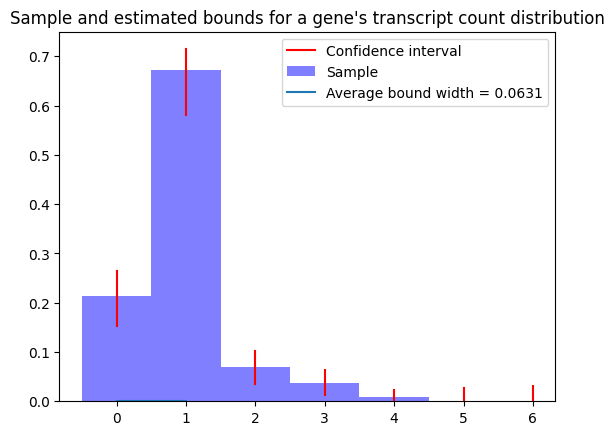

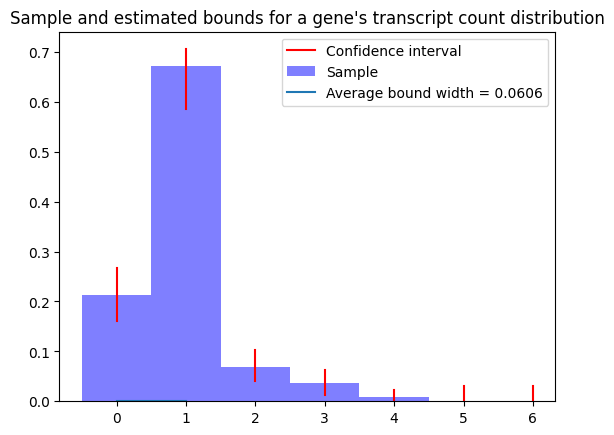

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


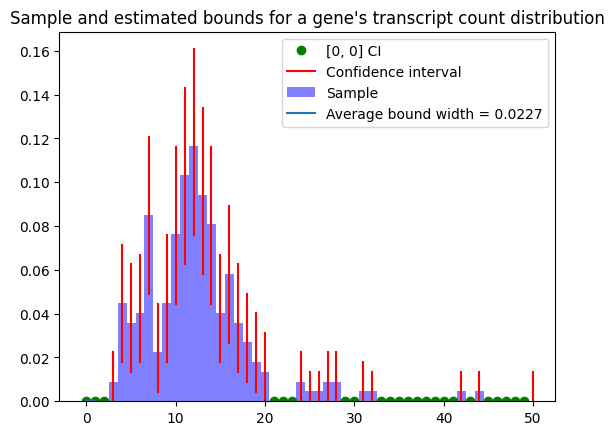

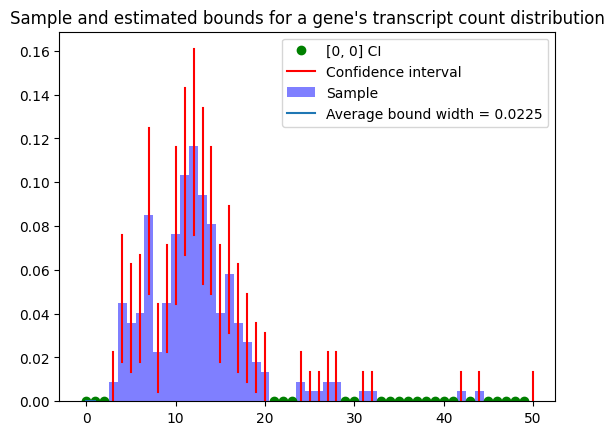

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\random.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [population[floor(random() * n)] for i in _repeat(None, k)]


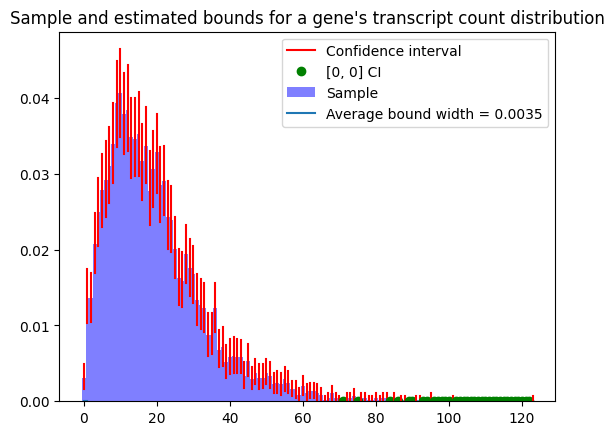

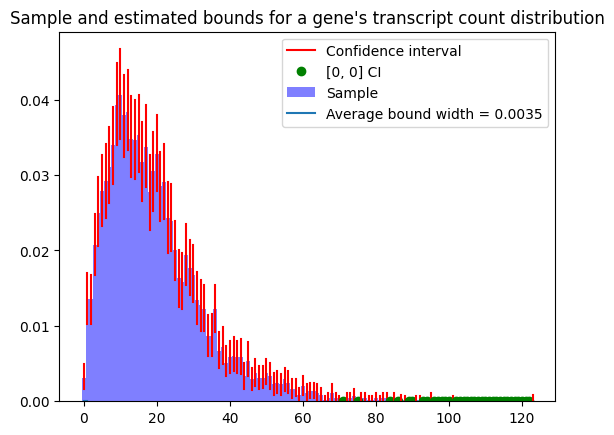

In [251]:
for data in [data_OB, data_MAP, data_PS]:
    sample = data.iloc[1483]
    CI_analysis(sample, 1000)
    CI_analysis_optim(sample, 1000)

Almost identical results (slight differences exepect due to random sampling), dropping/replacing nan values may slightly affect but overall massive speedup with same result.